# Air Drag Calculations

This notebook uses data collected from our physics lab to determine if air drag is correlated to v or v^2

The data collected was mean terminal velocity and standard deviation for various masses

Since at terminal velocity the force of gravity is equal to the force of air drag,
the mass should be linearly correlate to the force of air drag. So, whichever quantity,
v or v^2, is better correlated to mass, we would expect to be better correlated to the force
of air drag.

In [23]:
from uncertainties import ufloat
import numpy as np
import math

Here we take our data and put in arrays, and we make sure they all have the same length

In [24]:
mean_v_term = [0.7,0.7,0.69,0.88,0.94,0.99,1.36,1.43,1.42,1.67,1.61,1.61,1.9,1.95,1.98]
std_dev = [.14,.09,.12,.06,.08,.08,.05,.17,.13,.13,.08,.14,.20,.15,.11]
mass_measured = [*[1.07] * 3, *[1.89] * 3, *[2.85] * 3, *[3.66] * 3, *[4.70] * 3]

print(np.shape(mean_v_term))
print(np.shape(std_dev))
print(np.shape(mass_measured))

(15,)
(15,)
(15,)


Next we want to convert these values into measurements with uncertainties.
We let std_dev = .02 g because that seems reasonable idk.

In [25]:
def toUncertainties(values, std_dev):
    return [ufloat(v,e) for v,e in zip(values,std_dev)]

velocity = toUncertainties(mean_v_term,std_dev)
mass = toUncertainties(mass_measured,[.02 for _ in range(0, len(mass_measured))])

print("First three measurements for velocity (m/s):\n" + str(velocity[:3]))
print("First three measurements for mass (g):\n" + str(mass[:3]))

First three measurements for velocity (m/s):
[0.7+/-0.14, 0.7+/-0.09, 0.69+/-0.12]
First three measurements for mass (g):
[1.07+/-0.02, 1.07+/-0.02, 1.07+/-0.02]


In [26]:
def avg(list): #library doesn't support lambdas/reduce :(
    sum = 0
    for value in list:
        sum += value
    return sum/len(list)

def correlation_squared(list1, list2):
    avg1 = avg(list1)
    avg2 = avg(list2)
    uppersum = 0
    square1 = 0
    square2 = 0
    for value1, value2 in zip(list1,list2):
        uppersum += (value1 - avg1)*(value2 - avg2)
        square1 += (value1 - avg1)**2
        square2 += (value2 - avg2)**2
    return uppersum**2 / (square1*square2)

coeff_for_v = correlation_squared(velocity,mass)
coeff_for_squared = correlation_squared([v**2 for v in velocity],mass)

print("Correlation coeff for velocity: " + str(coeff_for_v))
print("Correlation coeff for velocity squared: " + str(coeff_for_squared))

Correlation coeff for velocity: 0.985+/-0.019
Correlation coeff for velocity squared: 0.983+/-0.016


Yeah, so this package is pretty trash for doing any useful stats ngl. It's wrap() function rarely works so
you have to roll your own stats library, but at least I got a result out of it. Unfortunately it was the wrong result
(air drag *is* proportional to v sqaured), but even if it was the correct result regardless we should probably re-engineer
our experiment because these correlation coefficients are too close.

We can do a t score test to determine exactly how close:

In [27]:
def t_score(value1, value2):
    return abs((value1.n - value2.n)/math.sqrt(value1.s**2 + value2.s**2))

print("t score: " + str(t_score(coeff_for_v,coeff_for_squared)))

t score: 0.08606300601931852


Which is very low. Which is a good t score, which is bad because it suggests we're sampling from the same distribution
which really means we didn't show a significant difference between the two.


|t score| meaning|
|--|--|
| <1 | high confidence that we're sampling <br> from the same distribution |
| 1 < t < 3 | inconclusive, re-test |
| t > 3 | high confidence that we're **not** sampling <br> from the same distribution |

In the future when we re-design our experiment, testing with greater forces should result in higher
velocities, where the disparity between the correlations will hopefully become apparent.

Just for kicks, what does this data plotted look like?

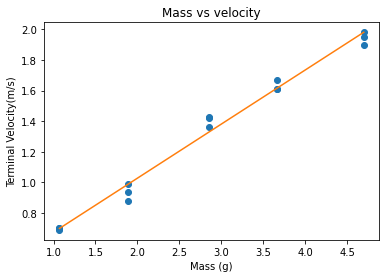

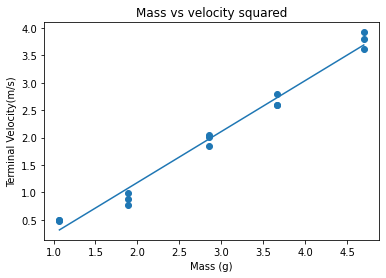

In [28]:
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

x = np.array(mass_measured)
y = np.array(mean_v_term)
y_squared = np.array([v**2 for v in mean_v_term])

plt.scatter(x,y)
plt.title("Mass vs velocity")
plt.xlabel("Mass (g)")
plt.ylabel("Terminal Velocity(m/s)")
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()


plt.title("Mass vs velocity squared")
plt.scatter(x,y_squared)
plt.xlabel("Mass (g)")
plt.ylabel("Terminal Velocity(m/s)")
b, m = polyfit(x, y_squared, 1)
plt.plot(x, b + m * x, '-')
plt.show()

It's basically improssible to tell which is a better fit, which is why we need to re-test.